In [1]:
from typing import AnyStr
import os
os.chdir("..")
os.chdir("src")
from data_cleaning import DataCleaning
import polars as pl
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt
import nltk
from unidecode import unidecode
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
os.chdir("..")

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cleaning_pipeline = DataCleaning()
df = cleaning_pipeline.run()

2024-03-28 18:39:43 - INFO - Data loaded!
2024-03-28 18:39:43 - INFO - Data types asserted!
2024-03-28 18:39:43 - INFO - Null values cleaned!
2024-03-28 18:39:43 - INFO - Full data cleaned!


## Checking the most common tokens

In [3]:
ds_objetos_array = df.select("DS_OBJETO").collect().to_numpy().flatten()

In [4]:
def frequencia_palavras(lista_texto, top_n=15, orient='v', figsize=(8, 6)):
    lista_texto = np.where(pd.isnull(lista_texto), '', lista_texto)

    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(lista_texto)
    features = vectorizer.get_feature_names_out()

    fig, ax = plt.subplots(figsize=figsize)
    visualizer = FreqDistVisualizer(features=features, orient=orient, n=top_n, ax=ax)
    visualizer.fit(docs)
    visualizer.show()

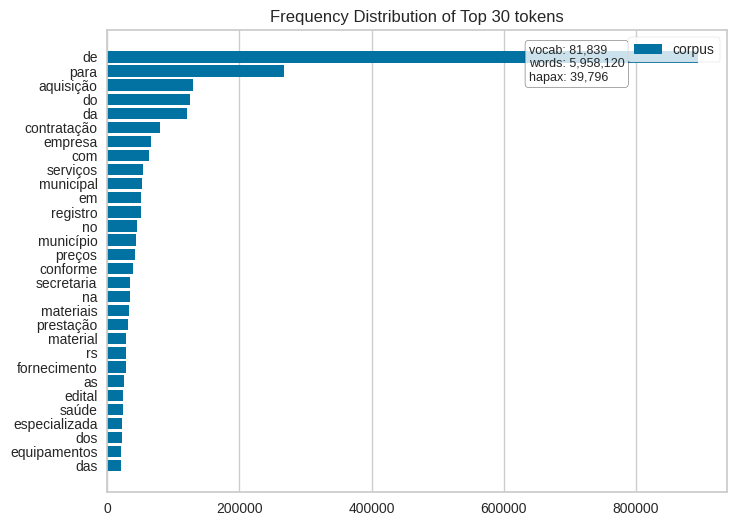

In [5]:
frequencia_palavras(ds_objetos_array, 30, 'h')

## Removing stopwords and cleaning the data:

In [6]:
def remove_stop_words(words):
    stop_words = stopwords.words('portuguese')
    return [word for word in words if word.lower() not in stop_words]

def preprocess(x: AnyStr) -> str:

    special_chars = "¨'!#$%&()*+,./:;<=>?@[\]^_`{|}~"
    new_x = x.replace('"',' ')
    for c in special_chars:
        new_x = new_x.replace(c,' ') # Removes special characters
    new_x = re.sub(r'[^\w\s]', ' ', new_x) # Removes punctuation
    new_x = re.sub("http\S+", ' ',new_x) # Removes links
    new_x = re.sub("@\w+", ' ',new_x) # Removes @
    new_x = re.sub('#\S+', ' ',new_x) # Removes hashtags
    new_x = re.sub('[0-9]+', ' ',new_x) # Removes numbers
    new_x = unidecode(new_x) # Removes accents
    new_x = re.sub("\s+", ' ',new_x) # Removes spaces

    new_x = ' '.join([word for word in new_x.split() if len(word) > 2])
    
    new_x = new_x.strip()
    return new_x

In [7]:
df = df.with_columns(
    pl.col("DS_OBJETO")
    .map_elements(lambda x: nltk.word_tokenize(x.lower(), language='portuguese')) # Tokenize
    .map_elements(lambda x: [preprocess(word) for word in x]) # Other preprocessing
    .map_elements(lambda arr: list(filter(None, arr))) # Removes items with none
    .map_elements(remove_stop_words, return_dtype=pl.List(pl.String)) # Removes stop words
    .alias("DS_OBJETO_NLP")
)

In [8]:
lista_obj = df.select("DS_OBJETO_NLP").collect().to_numpy().flatten()
ds_objetos_array_nlp = np.concatenate(lista_obj).astype(str)

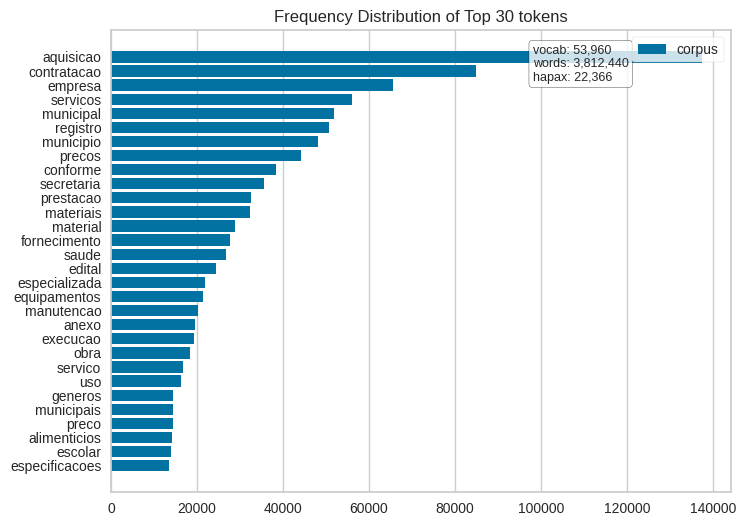

In [9]:
frequencia_palavras(ds_objetos_array_nlp, 30, 'h')

Now let's add more stopwords to remove, in this case, words that contribute little to the clustering, as they are very present in the corpus.

In [22]:
def new_remove_stop_words(words):
    stop_words = stopwords.words("portuguese")
    new_stopwords = [
    "aquisicao",
    "aquisicoes",
    "conforme",
    "contratacao",
    "empresa",
    "servicos",
    "registro",
    "municipal",
    "municipio",
    "precos",
    "secretaria",
    "prestacao",
    "materiais",
    "material",
    "rs",
    "fornecimento",
    "edital",
    "no",
    "especializada",
    "equipamentos",
    "manutencao",
    "anexo",
    "execucao",
    "uso",
    "generos",
    "municipais",
    "preco",
    "ano",
    "mes",
    "dia",
    "anos",
    "meses",
    "dias",
    "kg",
    "especificacoes",
    "secretarias",
    "mao",
    "termo",
    "referencia",
    "licitacao",
    "licitacoes",
    "pregao",
    "sistema",
    "atender",
    "atraves",
    "publica",
    "camara",
    "demais",
    "vereadores",
    "sec",
    "solicitacao",
    "licitatorio",
    "tipo",
    "anexos",
    "anexo",
    'referente',
    'atendimento',
    'utilização',
    'destinados',
    'solicitado',
    'sob',
    'humano',
    'demandas',
    'necessidade',
    'demandar',
    'presente',
    'acordo',
    'outros',
    'parcelada',
    'preços',
    'compra',
    'viacao',
    'legislativo',
    'necessidades',
    'serem',
    'realizacaosecretarias',
    'sendo',
    'solicito',
    'garantia',
    'objeto',
    'futura',
    'diversas',
    'constitui',
    'demanda',
    'diversos',
    'solicitar',
    'constantes',
    'repasse',
    'novos',
    'judicial',
    'prefeitura',
    'emenda',
    'recurso',
    'legislativa',
    'protocolo',
    'deste',
    "eventos",
"nova",
"selecao",
"credenciamento",
"nao",
"rede",
"social",
"projeto",
"area",
"global",
"bens",
"processo",
"eventual",
"assistencia",
"sul",
"realizacao",
"periodo",
"programa",
"centro",
"regime",
"locacao",
"visando",
"lei",
"sao",
"novo",
"meio",
"publico",
"horas",
"condicoes",
"presencial",
"realizados",
"pessoa",
"memorial",
"juridica",
"tecnicos",
"projetos",
"elaboracao",
"expediente",
"unidade",
"unidades",
"desenvolvimento",
"descritivo",
"atividades",
"utilizacao",
"conserto",
"contrato",
"junto",
"futuras",
"semanas",
"nova",
"ate",
"minimo",
"credenciamento",
"convenio",
"bairro",
"lugar",
"selecao",
"participarem",
"participar",
"um",
"dois",
"tres",
"quatro",
"cinco",
"seis",
"sete",
"oito",
"nove",
"dez",
"onze",
"doze",
"eventos",
"publicos",
"incluindo",
"neste",
"pecas",
"administracao",
"gerenciamento",
"fornecimento",
"especializados",
"bem",
"ministerio",
"ampliacao",
"tecnico"
"tecnica",
"grande",
"implantacao",
"proposta",
"cras",
"basicas",
"linha",
"geral",
"rio",
"nacional",
"entrega",
"zero",
"realizar",
"menor",
"maior",
"utilizados",
"total",
"101",
"111",
"126",
"planilha",
"alegre",
"servidores",
"cronograma",
"estado",
"santa",
"administracao",
"administrativo",
"distribuicao",
"porto",
"ata",
"publicas",
"gestao",
"pessoas",
"trabalho",
"fisico",
"parte",
"cidade",
"federal",
"necessarios",
"item",
"conformidade",
"assessoria",
"sede",
"mao",
"dados",
"serao",
"exclusivo",
"acesso",
"emef",
"orcamentaria",
"orcamento",
"destinado",
"suprir",
"jose"
"cbuq",
"lote",
"epp",
"objetivando",
"objetivo",
"pnae",
"permanente",
"proprios",
"todas",
"todos",

    ]
    new_stopwords.extend(stop_words)


    return [word for word in words if word.lower() not in new_stopwords]


In [8]:
df = df.with_columns(
    pl.col("DS_OBJETO")
    .map_elements(lambda x: nltk.word_tokenize(x.lower(), language='portuguese')) # Tokenize
    .map_elements(lambda x: [preprocess(word) for word in x]) # Other preprocessing
    .map_elements(lambda arr: list(filter(None, arr))) # Removes items with none
    .map_elements(new_remove_stop_words, return_dtype=pl.List(pl.String)) # Removes stop words
    .map_elements(lambda x: [word for word in x if "rs" not in word]) # Remove tokens containing "rs" (which are cities)
    .alias("DS_OBJETO_NLP_NEW")
)

In [9]:
lista_obj_new = df.select("DS_OBJETO_NLP_NEW").collect().to_numpy().flatten()
ds_objetos_array_nlp_new = np.concatenate(lista_obj_new).astype(str)

In [10]:
def frequencia_palavras(lista_texto, top_n=15, orient='v', figsize=(8, 6)):
    lista_texto = np.where(pd.isnull(lista_texto), '', lista_texto)

    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(lista_texto)
    features = vectorizer.get_feature_names_out()
    
    fig, ax = plt.subplots(figsize=figsize)
    visualizer = FreqDistVisualizer(features=features, orient=orient, n=top_n, ax=ax)
    visualizer.fit(docs)
    visualizer.show()

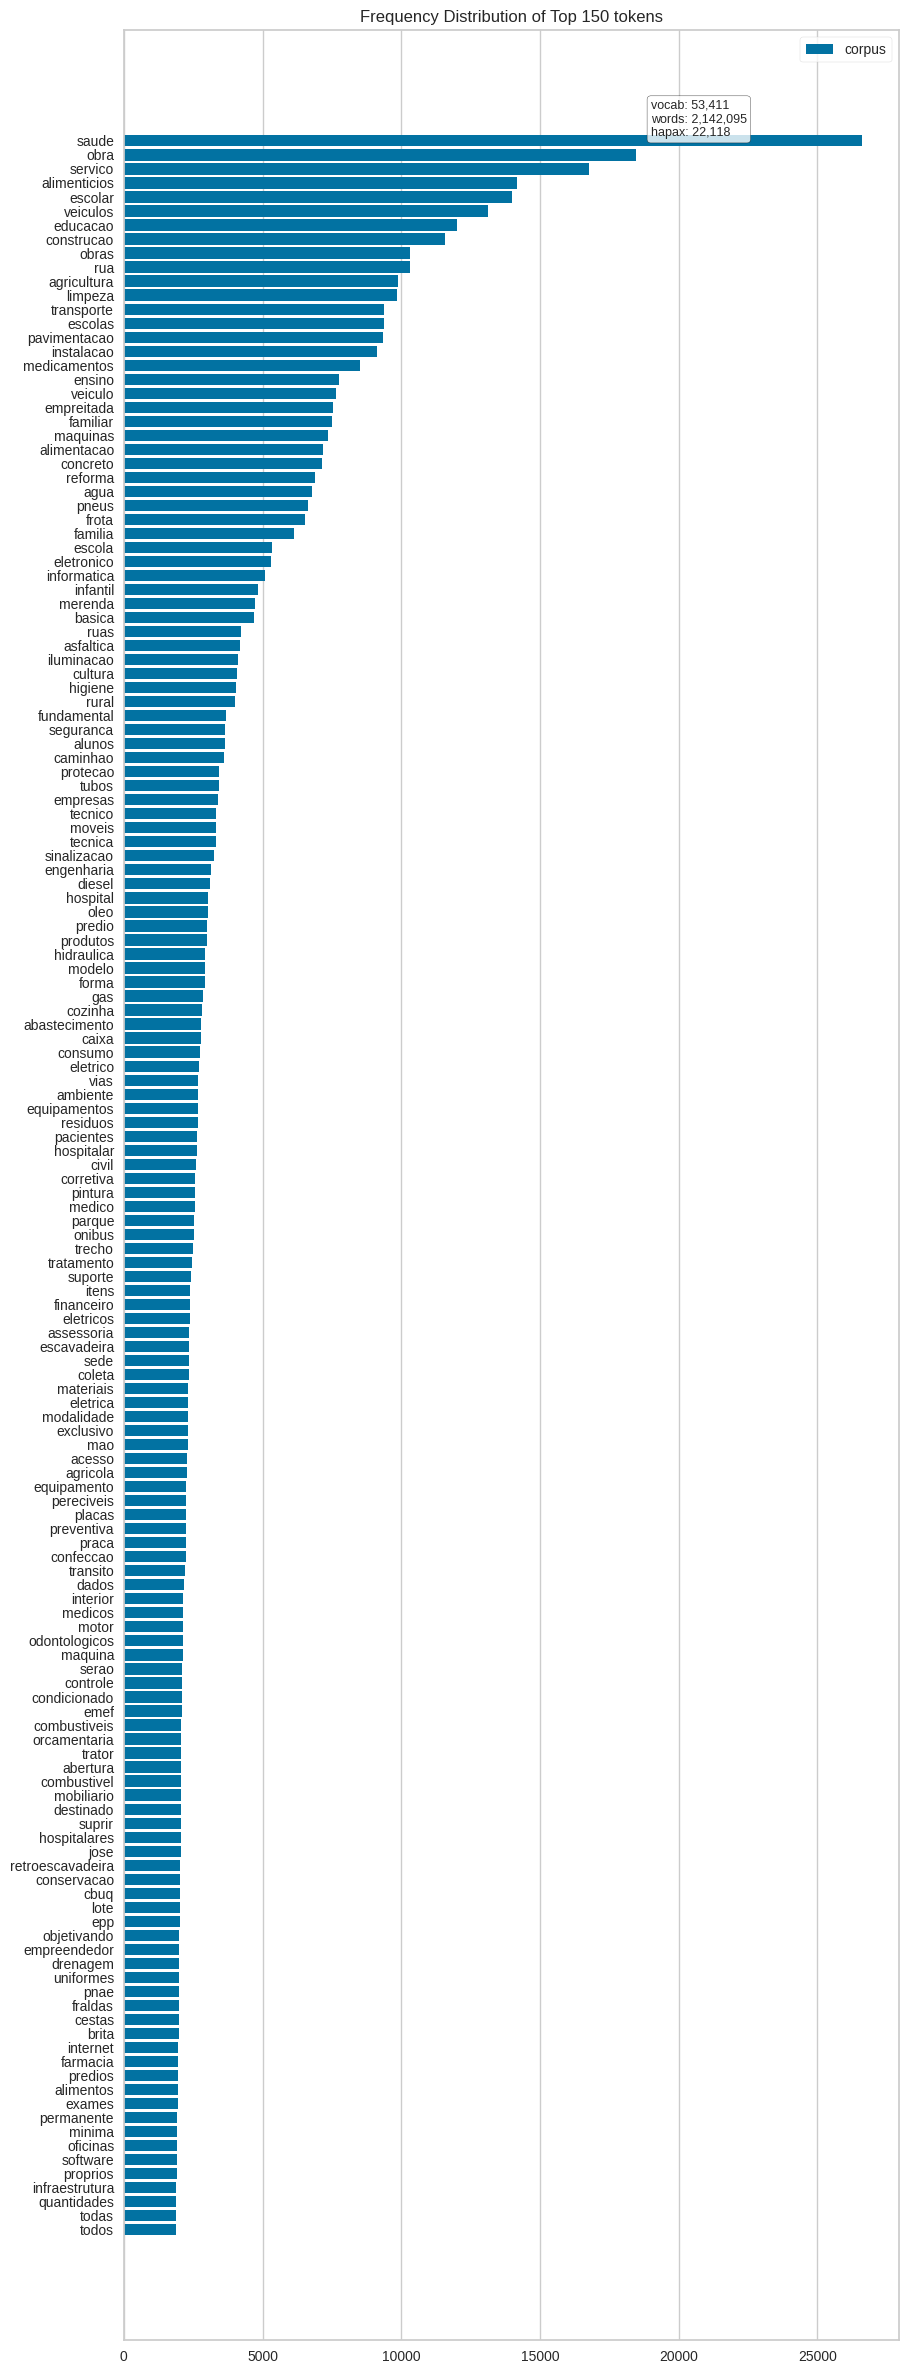

In [12]:
frequencia_palavras(ds_objetos_array_nlp_new, 150, 'h', figsize=(10, 30))

So, we saved the stop words from https://github.com/stopwords-iso/stopwords-pt along with the stop words specific to our problem. Now it can be easily loaded:

In [28]:
stop_words = []

with open("stop_words.txt", "r") as file:
    for row in file:
        stop_words.append(row.strip())